# 4 降噪自编码器（Denoising Autoencoder）
> 自编码器简介：
> 自编码器是一种特殊类型的神经网络，经过训练可以将输入复制到输出。学习过后，它可以将数据压缩为低维的潜在表示，再根据低维信息重建原始信息，试图达到最小的误差。换句话说，自编码器会学习数据中比较明显的、特异性的特征，而忽略那些不那么重要的细节。
> 利用自编码器的这种特点，我们可以在训练数据的输入中添加噪音，让自编码器去学习降噪，这就是降噪自编码器

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
# 加载数据
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## 标准自编码器

In [3]:
# 压缩后输出的维度数
latent_dim = 64 

# 定义模型类
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(28*28, activation='sigmoid'),
            tf.keras.layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 构建模型 
autoencoder = Autoencoder(latent_dim) 

In [4]:
# 编译模型
autoencoder.compile(optimizer='adam', loss=tf.losses.MeanSquaredError())

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0242 - val_loss: 0.0134
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0118 - val_loss: 0.0108
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0090 - val_loss: 0.0092
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.00

In [6]:
# 用模型进行预测
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

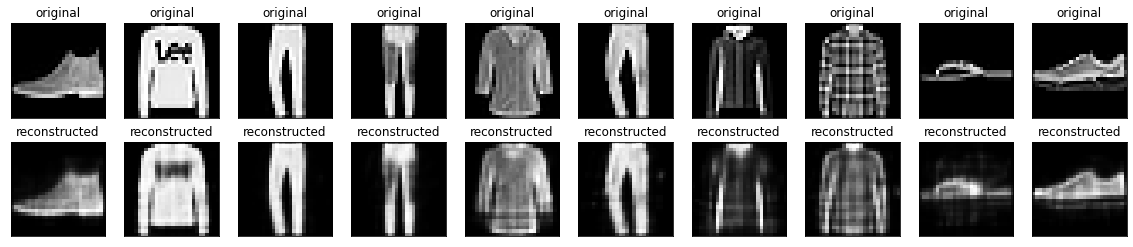

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## 降噪自编码器

In [8]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# 重要！添加一个维度
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [10]:
# 添加噪音
noise_factor = 0.2 # 噪音因子
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

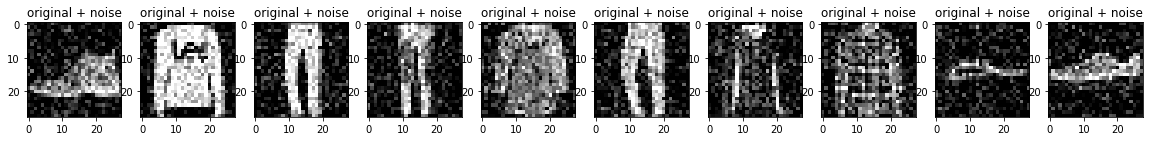

In [11]:
# 查看添加噪音的图片
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [12]:
# 构建降噪自编码器模型
class Denoise(tf.keras.Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
            tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [13]:
# 编译模型
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [14]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 94s 50ms/step - loss: 0.0164 - val_loss: 0.0103
Epoch 2/10
1875/1875 [==============================] - 95s 51ms/step - loss: 0.0093 - val_loss: 0.0088
Epoch 3/10
1875/1875 [==============================] - 118s 63ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 4/10
1875/1875 [==============================] - 103s 55ms/step - loss: 0.0079 - val_loss: 0.0077
Epoch 5/10
1875/1875 [==============================] - 99s 53ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 6/10
1875/1875 [==============================] - 101s 54ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 7/10
1875/1875 [==============================] - 99s 53ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 8/10
1875/1875 [==============================] - 97s 52ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 9/10
1875/1875 [==============================] - 95s 51ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 10/10
1875/1875 [==============================] - 94s 

In [15]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

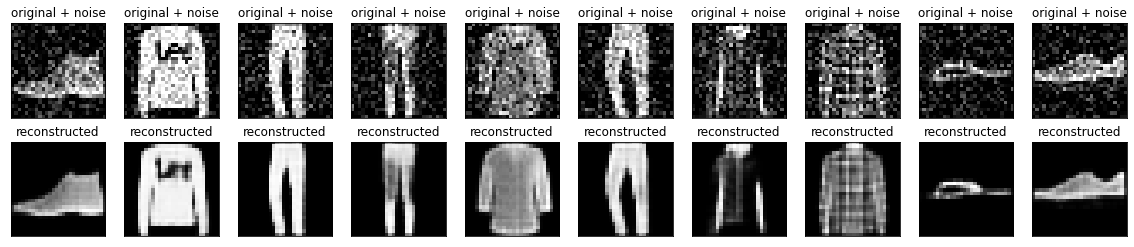

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()